In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from skimage import color
from skimage import io
import numba
from numba import jit

from IPython.display import HTML

# Laplace Equation

Remember that:

$$\frac{\partial}{\partial x} f = \frac{f_{k+1} - f_{k}}{\Delta x}$$

and

$$\frac{\partial^2}{\partial x^2} f = \frac{1}{\Delta x} [\frac{f_{k+1} - f_{k}}{\Delta x} - \frac{f_{k} - f_{k-1}}{\Delta x}] = \frac{f_{k+1} - 2f_{k} + f_{k-1}}{(\Delta x)^2}$$

Laplaces Equation:

$$\nabla^2 V=0$$

everywhere in the square. We are in 2D, so this means

$$\frac{\partial^2 V}{\partial x^2}+\frac{\partial^2 V}{\partial y^2}=0$$

This equation can be discretely approximated as

$$\frac{V(x_{i+1}, y_j) - 2V(x_i, y_j) + V(x_{i-1}, y_j)}{(\Delta x)^2} + \frac{V(x_i, y_{j+1}) - 2V(x_i, y_j) + V(x_i, y_{j-1})}{(\Delta y)^2} = 0 $$

Noting that $ \Delta x = \Delta y$ in our array, we can solve for $V(x_i, y_j)$ yielding

$$V(x_i, y_j) = \frac{1}{4}(V(x_{i+1}, y_{j}) + V(x_{i-1}, y_{j}) + V(x_{i}, y_{j+1}) + V(x_{i}, y_{j-1}))$$

So the idea is that if repeatedly set

$$V(x_i, y_j) \to \frac{1}{4}(V(x_{i+1}, y_{j}) + V(x_{i-1}, y_{j}) + V(x_{i}, y_{j+1}) + V(x_{i}, y_{j-1}))$$

$V$ will eventually converge to the true solution

# Case 1: Simple Boundary Conditions Only

Define the boundary conditions

In [3]:
edge = np.linspace(-1, 1, 300)
upper_y = np.cos(np.pi * edge / 2)
lower_y = edge**4
upper_x = 1/(np.e**-1 - np.e) * (np.exp(edge)-np.e)
lower_x = 0.5 * (edge**2-edge)

Plot the boundary conditions

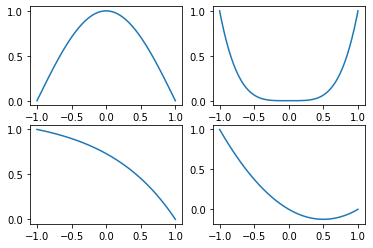

In [4]:
plt.subplot(2,2,1)
plt.plot(edge, upper_y)

plt.subplot(2,2,2)
plt.plot(edge, lower_y)

plt.subplot(2,2,3)
plt.plot(edge, upper_x)

plt.subplot(2,2,4)
plt.plot(edge, lower_x)
plt.show()

Get a meshgrid

In [5]:
xv, yv = np.meshgrid(edge, edge)

Define function to solve for the potential

In [6]:
@numba.jit("f8[:,:](f8[:,:], i8)", nopython=True, nogil=True)
def compute_potential(potential, n_iter):
  '''
  n_iter: number of iterations you wish to loop
  '''
  length = len(potential[0])
  for n in range(n_iter):
    for i in range(1, length-1):
      for j in range(1, length-1):
        potential[j][i] = 1/4 * (potential[j+1][i] + potential[j-1][i] + potential[j][i+1] + potential[j][i-1])
  return potential

Solve for potential

In [7]:
# Init
potential = np.zeros((300,300))

# The boundary conditions
potential[0,:]= lower_y
potential[-1,:]= upper_y
potential[:,0]= lower_x
potential[:,-1]= upper_x

# Calc. the potential
potential = compute_potential(potential, n_iter=10000)

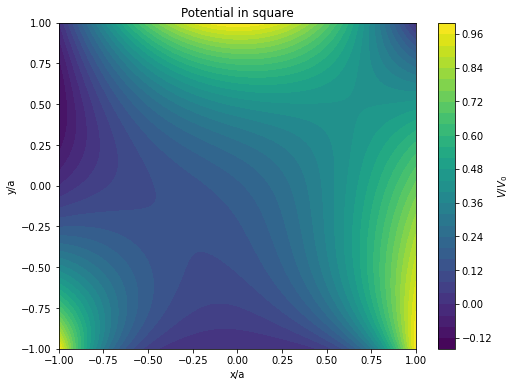

In [8]:
# Plot the solution
fig, ax = plt.subplots(1, 1, figsize=(8,6))

clr_plot = ax.contourf(xv, yv, potential, 30)

ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(clr_plot, label='$V/V_0$')
ax.set_title('Potential in square')

plt.show()

# Case 2: Block of Fixed Potential

Define a block which is set at a constant potential of $V=1$

In [9]:
def potential_box(x, y):
  '''
  Inside the box the potential is = 1
  Outside the box the potential is = 0
  '''
  return np.select([(x>0.)*(x<0.8)*(y>0.)*(y<0.8), (x<=0.)+(x>=0.8)+(y<=0.)+(y>=0.8)],
                   [1., 0.])

Show the location of the fixed potential

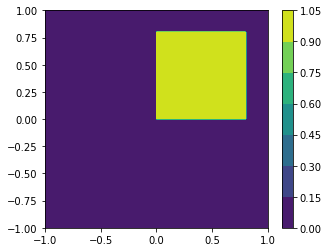

In [10]:
plt.figure(figsize=(5,4))
plt.contourf(xv, yv, potential_box(xv,yv))
plt.colorbar()
plt.show()

Obtain the fixed potential, and the places where the potential is fixed

In [11]:
# Fixed potential
fixed = potential_box(xv,yv)

# Convert into boolean
# Inside the box: values = True
# Outside the box: values = False
fixed_bool = fixed!=0

Modify the compute potential function so it doesn't set the modify the points at the fixed potential during the training procedure

In [12]:
@numba.jit("f8[:,:](f8[:,:], b1[:,:], i8)", nopython=True, nogil=True)
def compute_potential(potential, fixed_bool, n_iter):
    length = len(potential[0])
    for n in range(n_iter):
        for i in range(1, length-1):
            for j in range(1, length-1):
                if not(fixed_bool[j][i]): # Outside the box
                    potential[j][i] = 1/4 * (potential[j+1][i] + potential[j-1][i] + potential[j][i+1] + potential[j][i-1])
    return potential

Solve for the potential

In [13]:
# Init
potential = np.zeros((300,300))

# Boundary conditions
potential[0,:]= lower_y
potential[-1,:]= upper_y
potential[:,0]= lower_x
potential[:,-1]= upper_x

# Fixed values
# Inside the box: values = True
# Outside the box: values = False
potential[fixed_bool] = fixed[fixed_bool]

# Calc. the potential
potential = compute_potential(potential, fixed_bool, n_iter=10000)

Plot

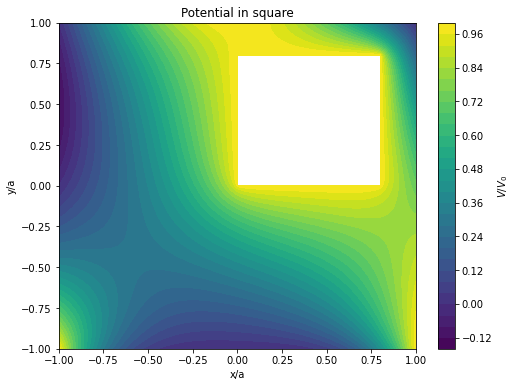

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

clr_plot = ax.contourf(xv, yv, potential, 33)

ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(clr_plot, label='$V/V_0$')
ax.set_title('Potential in square')

plt.show()

# Case 3: For an Image

Load image

In [27]:
img = color.rgb2gray(io.imread('accordion.png'))
img = np.flip(img, axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  """Entry point for launching an IPython kernel.


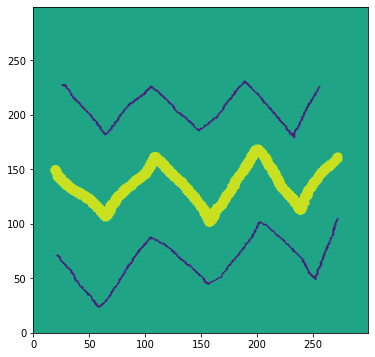

In [28]:
plt.figure(figsize=(6,6))
plt.contourf(img)
plt.show()

In [29]:
img

array([[0.48731255, 0.48731255, 0.48731255, ..., 0.48731255, 0.48731255,
        0.48731255],
       [0.48731255, 0.48731255, 0.48731255, ..., 0.48731255, 0.48731255,
        0.48731255],
       [0.48731255, 0.48731255, 0.48731255, ..., 0.48731255, 0.48731255,
        0.48731255],
       ...,
       [0.48731255, 0.48731255, 0.48731255, ..., 0.48731255, 0.48731255,
        0.48731255],
       [0.48731255, 0.48731255, 0.48731255, ..., 0.48731255, 0.48731255,
        0.48731255],
       [0.48731255, 0.48731255, 0.48731255, ..., 0.48731255, 0.48731255,
        0.48731255]])

In [30]:
from scipy import stats
stats.describe(img.flatten())

DescribeResult(nobs=90000, minmax=(0.0, 0.8184858823529412), mean=0.49022975683660125, variance=0.008997088398238455, skewness=-0.86089532233609, kurtosis=14.75719030043)

In [31]:
# High and Low Voltage
HV_bool = img < 0.05
LV_bool = img > 0.75

fixed_bool = HV_bool + LV_bool
fixed_bool

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

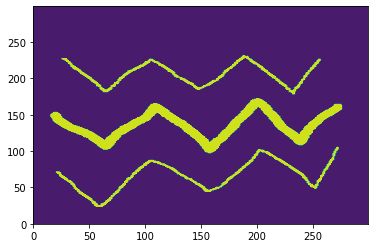

In [32]:
plt.contourf(fixed_bool)
plt.show()

In [33]:
fixed = img

In [34]:
nx, ny = img.shape
print(nx, ny)

300 300


Solve for potential

In [35]:
potential = np.zeros((nx,ny))

# Get potential from image
potential[fixed_bool] = fixed[fixed_bool]

# Boundary Conditions
potential[0,:]= lower_y[:ny]
potential[-1,:]= upper_y[:ny]
potential[:,0]= lower_x[:nx]
potential[:,-1]= upper_x[:nx]

# Calc. the potential (average of 4 neighbouring points)
potential = compute_potential(potential, fixed_bool, n_iter=10000)

Plot potential

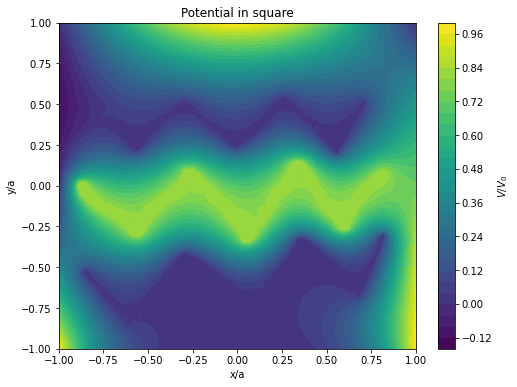

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

clr_plot = ax.contourf(xv[0:nx, 0:ny], yv[0:nx, 0:ny], potential, 30)

ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(clr_plot, label='$V/V_0$')
ax.set_title('Potential in square')

plt.show()

## Electric field magnitude

Electric field is the Negative of the Gradient of potential:

$$ \overrightarrow{E} = - \overrightarrow{\nabla} V$$

In [37]:
Ex, Ey = np.gradient(-potential)

# Magnitude
E_mag = np.sqrt(Ex**2 + Ey**2)

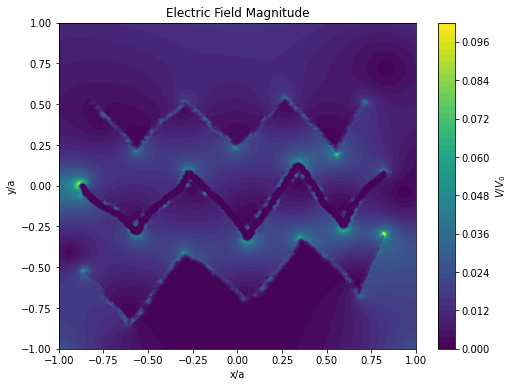

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

clr_plot = ax.contourf(xv, yv, E_mag, 50)

ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(clr_plot, label='$V/V_0$')
ax.set_title('Electric Field Magnitude')

plt.show()

## Make a 3D animation

In [39]:
def init():
    # Plot the surface.
    ax.plot_surface(xv, yv, potential, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('$x/a$')
    ax.set_ylabel('$y/a$')
    return fig,

def animate(i):
    ax.view_init(elev=30, azim=2*i) # View at different angles
    return fig,

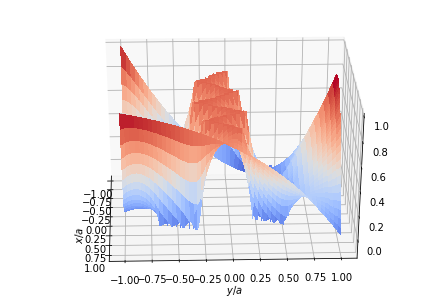

In [40]:
fig = plt.figure()
ax = Axes3D(fig)
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=180, interval=50)
ani.save('rotate_azimuth_angle_3d_surf.gif',writer='pillow',fps=20)

In [42]:
# Display the animation in the jupyter notebook
# from IPython.display import HTML
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.